# Eigen Modes

### References

* Ammon, C. J., et al. (2005), Rupture process of the 2004 Sumatra-Andaman earthquake, *Science, 308*, 1133–1139.
* Dahlen, F. A., and J. Tromp (1998), *Theoretical Global Seismology*, Princeton U. Press, Princeton, New Jersey, USA.
* Lay, T., et al. (2005), The great Sumatra-Andaman earthquake of 26 December 2004, *Science, 308*, 1127–1133.
* Ni, S., D. Helmberger, and H. Kanamori (2005), Energy radiation from the Sumatra earthquake, *Nature*, 434, 582.
* Park, J., et al. (2005), Earth’s free oscillations excited by the 26 December 2004 Sumatra Andaman earthquake, *Science, 308*, 1139–1144.
* Shearer, P. M. (2009), *Introduction to Seismology*, 2 ed., Cambridge U. Press, Cambridge, UK.
* Stein, S., and M. Wysession (2003), *An Introduction to Seismology, Earthquakes, and Earth Structure*, Blackwell, Malden, Mass., USA.

## Import Libraries

In [1]:
# Preparation for programming

%matplotlib inline

# do not show warnings
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pylab as plt

from obspy.core import read, UTCDateTime, Stream
from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal.filter import lowpass
from matplotlib.mlab import detrend
from obspy.signal.invsim import cosine_taper
from obspy.imaging.beachball import beach

# plt.style.use('ggplot')

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [3]:
# ## sumatra earthquake
# # t_origin = UTCDateTime("2004-12-26T00:58:53.0")

# ## tohoku earthquake
# # t_origin = UTCDateTime("2011-03-11T05:46:0.0"); event = 'tohoku'

# ## Kermadec earthquake
# # t_origin = UTCDateTime("2021-03-04T18:40:0.0"); event = 'kermadec'

# ## Alaska earthquakeabs
# t_origin = UTCDateTime("2024-04-02 00:11");
# event = 'Japan'


# stations = ["*.CAN.*.LHZ", "GR.BFO.*.LHZ", "GR.WET.*.LHZ", "BW.RLAS.*.BJZ"]
# clients  = ["IRIS", "BGR", "BGR", "LMU"]

# # stations = ["*.CAN.*.LHZ", "GR.BFO.*.LHZ", "GR.FUR.*.LHZ", "BW.ROMY.10.BJZ"]
# # clients  = ["IRIS", "BGR", "BGR","http://george"]


# starttime = t_origin - (24*3600*0.1)
# endtime   = t_origin + (24*3600*1.0)




In [4]:
config = {}

## Japan earthquake
config['t_origin'] = UTCDateTime("2024-04-02 23:58");


config['seeds'] = ["GR.BFO.*.LHZ",
                   "GR.WET.*.LHZ",
                   "GR.FUR.*.LHZ",
                   "BW.RLAS.*.BJZ",
                   "BW.ROMY.10.BJZ",]

config['repositories'] = ["online", "online", "online", "online", "archive"]

config['tbeg'] = config['t_origin']-10
config['tend'] = config['t_origin'] + 30*3600

config['path_to_sds'] = archive_path+"romy_archive/"


## as modelled by RPEM in muHz
free_modes = {'0S2':309.28, '0S3':468.56, '0S4':647.07, '1S2':679.85, '0S0':814.31, 
              '0S5':840.42, '1S3':939.83, '3S1':943.95}


## Import Data

In [28]:
from andbro__querrySeismoData import __querrySeismoData

st = Stream()
for seed, repo in zip(config['seeds'], config['repositories']):

    print(f" -> loading {seed} ({repo})")


    net, sta, loc, cha = seed.split(".")

    try:
        st0, inv =  __querrySeismoData(
                                        seed_id=seed,
                                        starttime=config['tbeg']-100,
                                        endtime=config['tend']+100,
                                        repository=repo,
                                        path=None,
                                        restitute=True,
                                        detail=None,
                                        fill_value=None,
                                       )
        st += st0
    except:
        print(f"  -> failed")

st = st.resample(1.0, no_filter=True)

st = st.trim(config['tbeg'], config['tend'], nearest_sample=False)

print(st)


 -> loading GR.BFO.*.LHZ (online)
 -> loading GR.WET.*.LHZ (online)
 -> loading GR.FUR.*.LHZ (online)
 -> loading BW.RLAS.*.BJZ (online)
 -> loading BW.ROMY.10.BJZ (archive)
5 Trace(s) in Stream:
GR.BFO..LHZ    | 2024-04-02T23:57:50.069538Z - 2024-04-04T05:57:59.069538Z | 1.0 Hz, 108010 samples
GR.WET..LHZ    | 2024-04-02T23:57:50.424999Z - 2024-04-04T05:57:59.424999Z | 1.0 Hz, 108010 samples
GR.FUR..LHZ    | 2024-04-02T23:57:50.640000Z - 2024-04-04T05:57:59.640000Z | 1.0 Hz, 108010 samples
BW.RLAS..BJZ   | 2024-04-02T23:57:50.992750Z - 2024-04-04T05:57:59.992750Z | 1.0 Hz, 108010 samples
BW.ROMY.10.BJZ | 2024-04-02T23:57:50.009799Z - 2024-04-04T05:57:59.009799Z | 1.0 Hz, 108010 samples


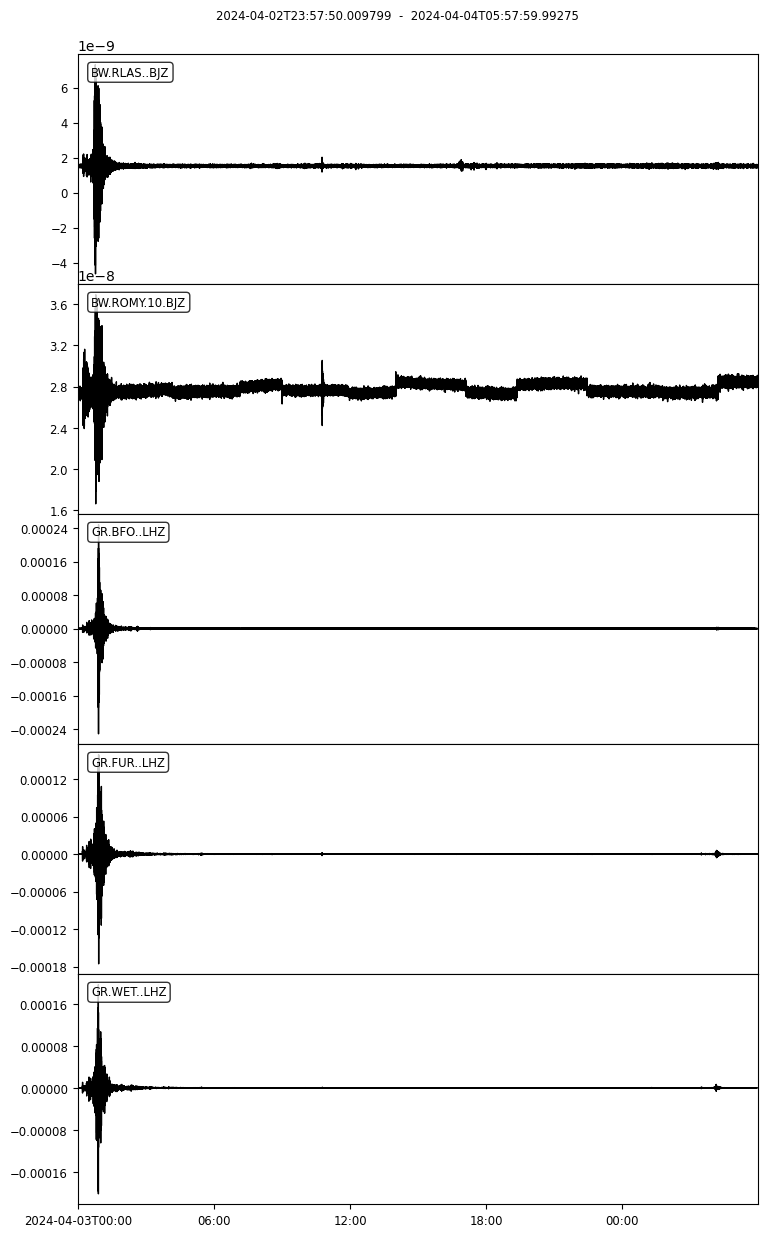

In [29]:
st.plot(equal_scale=False);

5 Trace(s) in Stream:
GR.BFO..LHZ    | 2024-04-03T02:57:50.069538Z - 2024-04-04T05:57:59.069538Z | 1.0 Hz, 97210 samples
GR.WET..LHZ    | 2024-04-03T02:57:50.424999Z - 2024-04-04T05:57:59.424999Z | 1.0 Hz, 97210 samples
GR.FUR..LHZ    | 2024-04-03T02:57:49.640000Z - 2024-04-04T05:57:59.640000Z | 1.0 Hz, 97211 samples
BW.RLAS..BJZ   | 2024-04-03T02:57:49.992750Z - 2024-04-04T05:57:59.992750Z | 1.0 Hz, 97211 samples
BW.ROMY.10.BJZ | 2024-04-03T02:57:50.009799Z - 2024-04-04T05:57:59.009799Z | 1.0 Hz, 97210 samples


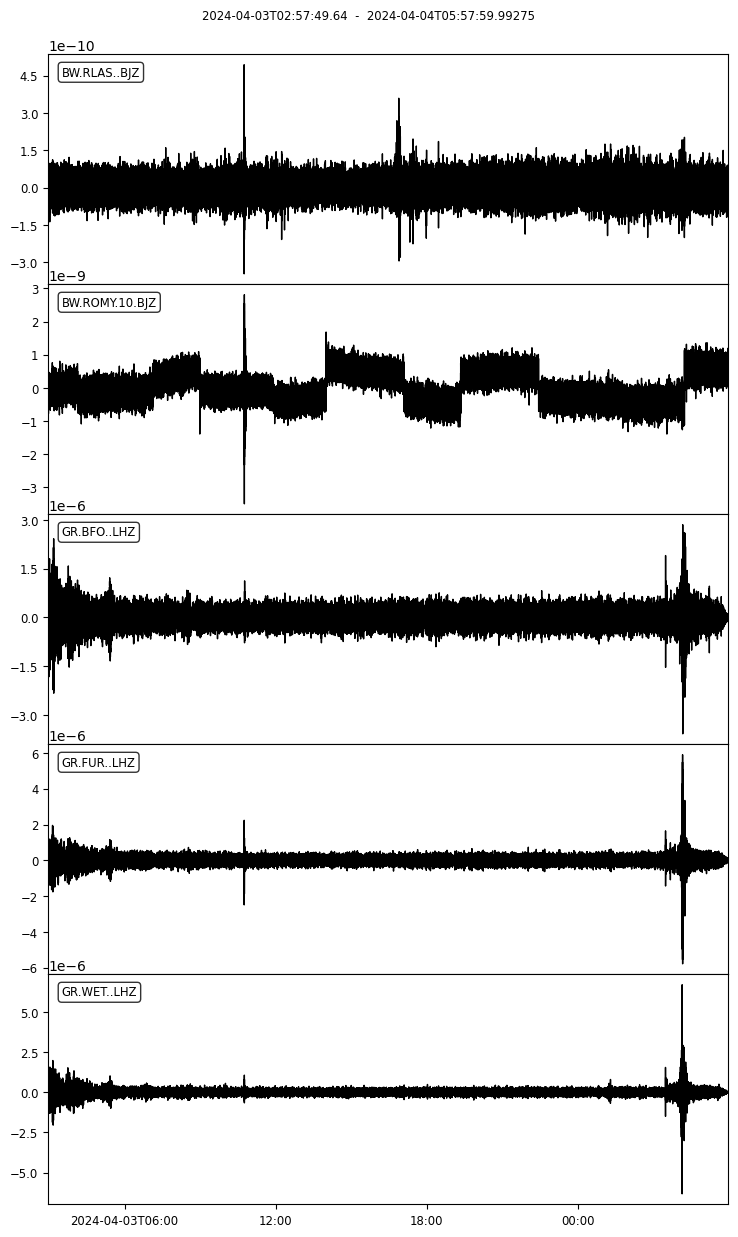

In [30]:
st1 = st.copy()

for tr in st1:
    tr = tr.trim(config['tbeg']+3*3600, config['tend'])

st1 = st1.detrend("linear")
# st1 = st1.filter("lowpass", freq=0.005, corners=4, zerophase=True)
# st1 = st1.filter("highpass", freq=1e-5, corners=4, zerophase=True)
# st1 = st1.detrend("linear")

print(st1)

del st

st1.plot(equal_scale=False);

### Calculating spectra of traces

In [31]:
def __make_spectra_fft(st):


    specs = []
    for j in st:

        print(j.data.size)

        y_tapered = j.data * cosine_taper(j.data.size, 0.1)     # Define cosine taper to be used
#         y_tapered = j.data * np.hanning(j.data.size)

        y_detrend = detrend(y_tapered, 'linear')

        y_fnew = np.fft.rfft(y_detrend)

#         y_pad = np.lib.pad(y_detrend, 
#                            (92289, 92289),
#                            'constant',
#                            constant_values=(0,0),
#                           )

#         y_fpad= np.fft.rfft(y_pad)

        specs.append(abs(y_fnew))

    freqs = np.linspace(0, 0.5*st[0].stats.sampling_rate, len(specs[0]))         

    return specs, freqs

In [32]:
specs, freqs = __make_spectra_fft(st1)

97210
97210
97211
97211
97210


GR.BFO.*.LHZ
GR.WET.*.LHZ
GR.FUR.*.LHZ
BW.RLAS.*.BJZ
BW.ROMY.10.BJZ


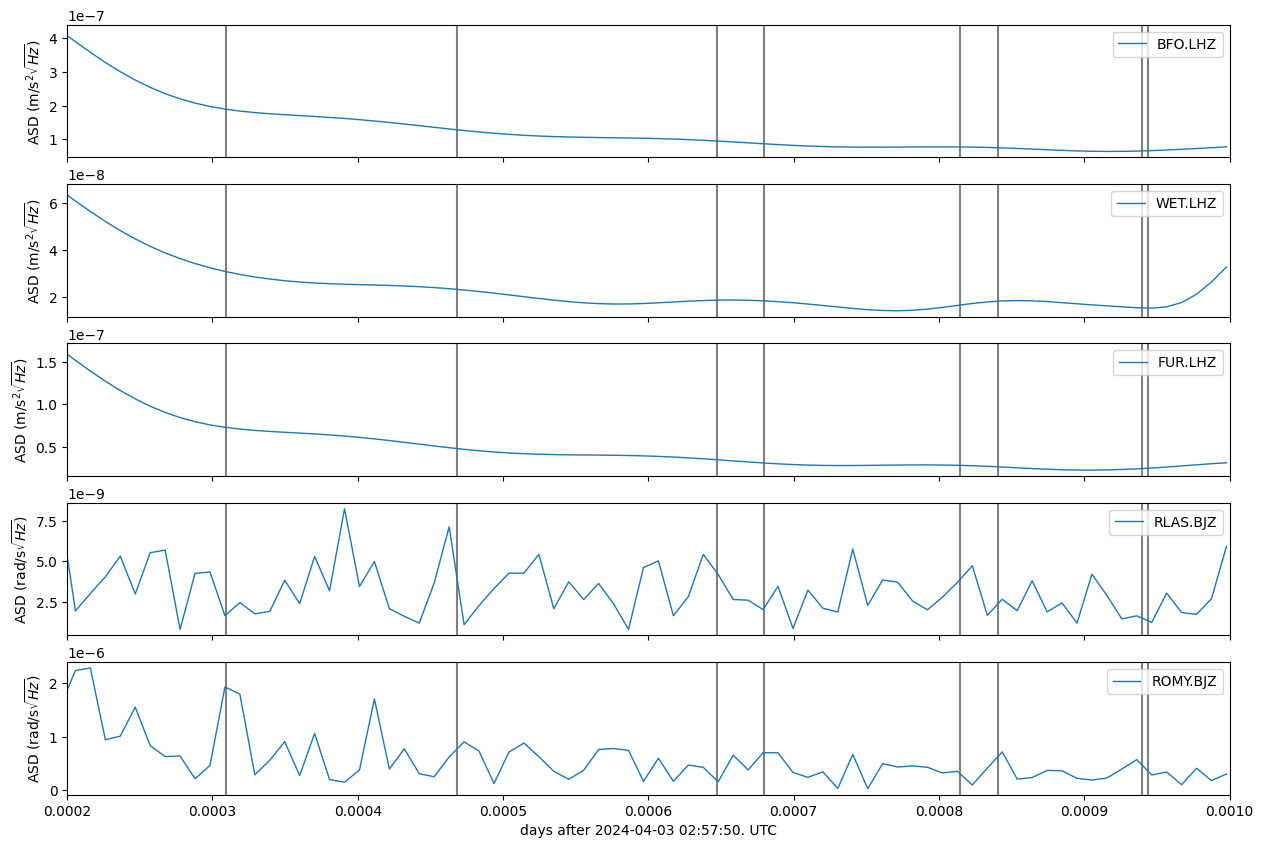

In [33]:
def __makeplot_spectra(st0, freqs, specs):

    fmax = 1e-3
    fmin = 2e-4

    for i, f in enumerate(freqs):
        if f > fmax:
            nmax = i
            break
    for i, f in enumerate(freqs):
        if f > fmin:
            nmin = i-1
            break

    time = np.linspace(0, st0[0].stats.npts*st0[0].stats.delta,  st0[0].stats.npts)

    N = len(config['seeds'])

    fig, ax = plt.subplots(N, 1, figsize=(15, 10), sharex=True)

    for i, seed in enumerate(config['seeds']):

        print(seed)

        net, sta, loc, cha = seed.split(".")

        ax[i].plot(freqs[nmin:nmax], specs[i][nmin:nmax], label=f'{sta}.{cha}', lw=1)

        if cha[1] == "J":
            ax[i].set_ylabel(r"ASD (rad/s$\sqrt{Hz}$)")
        else:
            ax[i].set_ylabel(r"ASD (m/s$^2$$\sqrt{Hz}$)")

        ax[i].legend(loc="upper right")

        ax[i].set_xlim(fmin, fmax)

        # ax[i].set_yscale("log")

        for mode in free_modes.values():
            ax[i].axvline(mode*1e-6, color='grey', zorder=0)


    ax[N-1].set_xlabel(f"days after {st0[0].stats.starttime.date} {str(st0[0].stats.starttime.time)[:9]} UTC")

    plt.show();

__makeplot_spectra(st1, freqs, specs)


In [34]:
def __make_spectra_welch(st, nsegments=int(100*4096)):

    from scipy.signal import welch

    specs = []

    for j in st:

        print(j.data.size)

        psd = welch(
                    j.data,
                    fs=j.stats.sampling_rate,
                    window='cosine',
                    nperseg=nsegments,
                    noverlap=None,
                    nfft=None,
                    detrend='constant',
                    return_onesided=True,
                    scaling='spectrum',
                    average='mean',
                    )

        specs.append(psd[1])

    freqs = psd[0]

    return specs, freqs

In [35]:

twin = 24 * 3600 # hours
nwin = int(twin * st1[0].stats.sampling_rate)

wspecs, wfreqs = __make_spectra_welch(st1, nsegments=nwin)
# wspecs, wfreqs = __make_spectra_welch(st1)

97210
97210
97211
97211
97210


GR.BFO.*.LHZ
GR.WET.*.LHZ
GR.FUR.*.LHZ
BW.RLAS.*.BJZ
BW.ROMY.10.BJZ


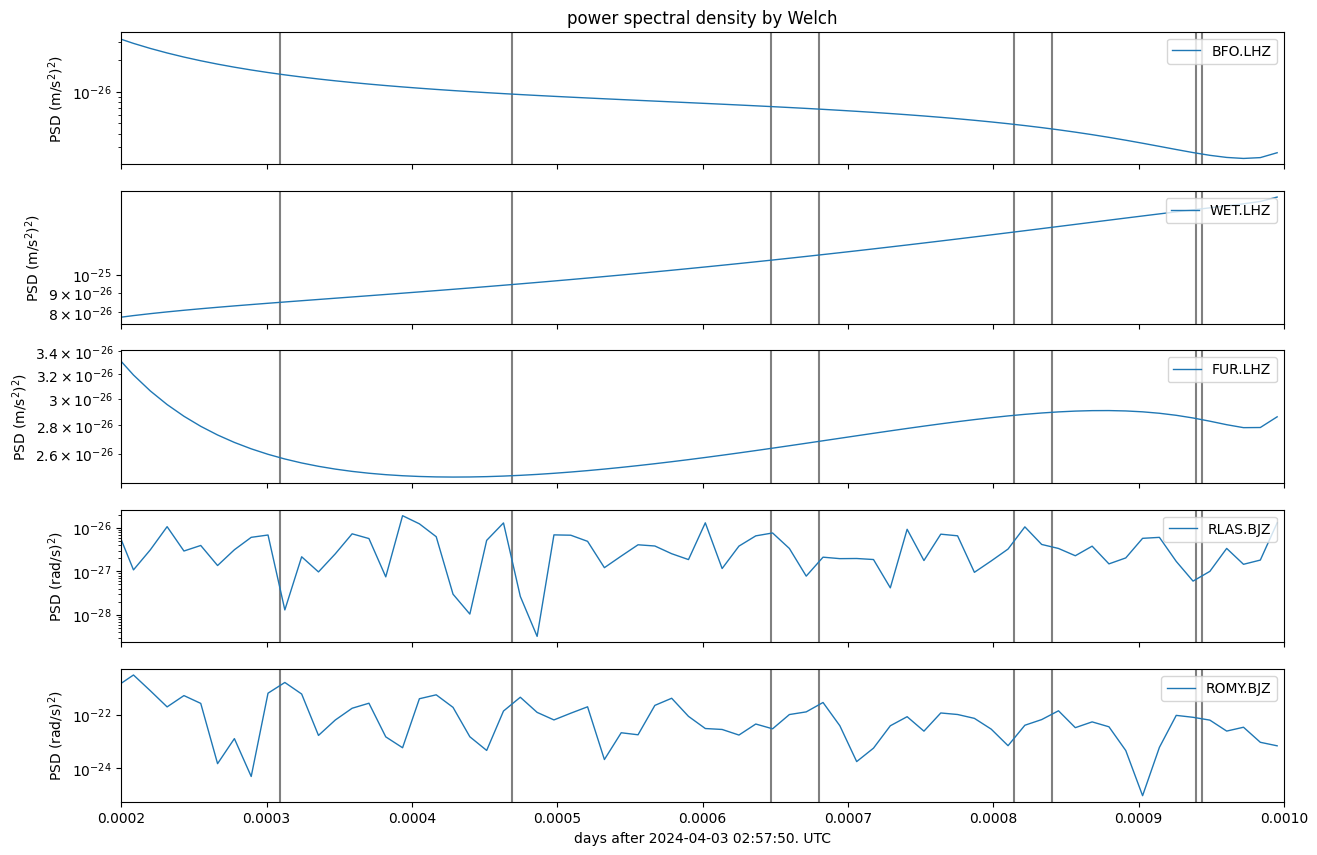

In [36]:
def __makeplot_spectra2(st0, freqs, specs):

    fmax = 1e-3
    fmin = 2e-4

    for i, f in enumerate(freqs):
        if f > fmax:
            nmax = i
            break
    for i, f in enumerate(freqs):
        if f > fmin:
            nmin = i-1
            break

    time = np.linspace(0, st0[0].stats.npts*st0[0].stats.delta,  st0[0].stats.npts)

    N = len(config['seeds'])

    fig, ax = plt.subplots(N, 1, figsize=(15, 10), sharex=True)

    for i, seed in enumerate(config['seeds']):

        print(seed)

        net, sta, loc, cha = seed.split(".")

        ax[i].semilogy(freqs[nmin:nmax], specs[i][nmin:nmax], label=f'{sta}.{cha}', lw=1, zorder=2)

        if cha[1] == "J":
            ax[i].set_ylabel(r"PSD (rad/s)$^2$)")
        else:
            ax[i].set_ylabel(r"PSD (m/s$^2$)$^2$)")

        ax[i].legend(loc="upper right")

        ax[i].set_xlim(fmin, fmax)

        for mode in free_modes.values():
            ax[i].axvline(mode*1e-6, color='grey', zorder=0)


    ax[N-1].set_xlabel(f"days after {st0[0].stats.starttime.date} {str(st0[0].stats.starttime.time)[:9]} UTC")

    ax[0].set_title("power spectral density by Welch")

    plt.show();

__makeplot_spectra2(st1, wfreqs, wspecs)


In [37]:
def __make_spectra_MT(st, method="unity"):

    from spectrum import data_cosine, dpss, pmtm

    window_length = st[0].stats.npts
    time_half_bandwidth = 2.5
    first_k_slepian_sequences = 2

    [tapers, eigen] = dpss(window_length, time_half_bandwidth, first_k_slepian_sequences)

    specs = []
    for j in st:

        print(j.data.size)


        if method == 'unity':

            ## call pmtm function of spectrum library
            sk_complex, weights, eigen = pmtm(j.data, e=eigen, v=tapers, show=False, method='unity')

            ## right scaling
            sk = abs(sk_complex)**2

            ## redefine weithgts, since wrong in dimension
            weights = np.transpose(np.ones(np.shape(sk)))

            ## multiply output sk matrix and weights matrix and average rows
            out = np.mean(np.matmul(weights,sk), axis=0)


        elif method == 'adapt':

            ## call pmtm function of spectrum library
            sk_complex, weights, eigen = pmtm(j.data, e=eigen, v=tapers, show=False, method='adapt')

            ## multiply output sk matrix and weights matrix and average rows

            ## right scaling
            sk = abs(sk_complex)**2

            ## multiply output sk matrix and weights matrix and average rows
            out = np.mean(np.matmul(weights,sk), axis=1)

        ## return one-sided spectrum
        out = out[:window_length//2]

        ## gather outputs
        specs.append(out)
        del out

    ## generate frequency axius
    freqs = np.linspace(0, 0.5*st[0].stats.sampling_rate, len(specs[0]))

    return specs, freqs

In [25]:

specsMT, freqsMT = __make_spectra_MT(st1, method="unity")

print(len(specsMT));

97210


MemoryError: Unable to allocate 128. GiB for an array with shape (131072, 131072) and data type float64

In [ ]:
def __makeplot_spectra_MT(st0, freqs, specs):

    fmax = 1e-3
    fmin = 2e-4

    for i, f in enumerate(freqs):
        if f > fmax:
            nmax = i
            break
    for i, f in enumerate(freqs):
        if f > fmin:
            nmin = i-1
            break

    time = np.linspace(0, st0[0].stats.npts*st0[0].stats.delta,  st0[0].stats.npts)

    N = len(config['seeds'])

    fig, ax = plt.subplots(N, 1, figsize=(15, 10), sharex=True)

    for i, seed in enumerate(config['seeds']):

        print(seed)

        net, sta, loc, cha = seed.split(".")

        ax[i].plot(freqs[nmin:nmax], specs[i][nmin:nmax], label=f'{sta}.{cha}', lw=1)

        if cha[1] == "J":
            ax[i].set_ylabel(r"ASD (rad/s$\sqrt{Hz}$)")
        else:
            ax[i].set_ylabel(r"ASD (m/s$^2$$\sqrt{Hz}$)")

        ax[i].legend(loc="upper right")

        ax[i].set_xlim(fmin, fmax)

        for mode in free_modes.values():
            ax[i].axvline(mode*1e-6, color='grey', zorder=0)

#     if event == 'kermadec':
#         ax[0].set_ylim(0, 0.0004)
#         ax[1].set_ylim(0, 0.0002)
#         ax[2].set_ylim(0, 0.0006)
#         ax[3].set_ylim(0, 0.5e-9)

#     if event == 'tohoku':
#         ax[0].set_ylim(0, 0.001)
#         ax[1].set_ylim(0, 0.001)
#         ax[2].set_ylim(0, 0.001)
#         ax[3].set_ylim(0, 1e-9)


    ax[N-1].set_xlabel(f"days after {st[0].stats.starttime.date} {str(st[0].stats.starttime.time)[:9]} UTC")

    plt.show();

__makeplot_spectra_MT(freqsMT, specsMT)


### Plotting Traces

In [ ]:
def __makeplot_traces(st0):


    time = np.linspace(0, st0[0].stats.npts*st0[0].stats.delta,  st0[0].stats.npts)

    N = len(stations)

    fig, ax = plt.subplots(N, 1, figsize=(15, 10), sharex=True)

    for i in range(N):

        print(st0[i])

        ax[i].plot(time/24/3600, st0[i].data, 'k', label=f"{st[i].stats.station}.{st0[i].stats.channel}", lw=1)

        ax[i].set_ylabel(r"amplitude (m/s$^2$)")

        ax[i].legend(loc="upper right")

    ## Kermadec
    # ax[0].set_ylim(-5e-5, 5e-5)
    # ax[1].set_ylim(-2e-5, 2e-5)
    # ax[2].set_ylim(-2.5e-5, 2.5e-5)
#     ax[3].set_ylim(-1e-10, 1e-10)

    ## Tohoku
#     ax[0].set_ylim(-5e-5, 5e-5)
#     ax[1].set_ylim(-2e-5, 2e-5)
#     ax[2].set_ylim(-2.5e-5, 2.5e-5)
#     ax[3].set_ylim(-1e-11, 1e-11)

    ax[N-1].set_xlabel(f"days after {st0[0].stats.starttime.date} {str(st0[0].stats.starttime.time)[:9]} UTC")

    plt.show();

__makeplot_traces(st1)


## Tests

In [ ]:
from obspy import Trace

fs = 10
t = np.arange(0, 1000/fs, 1/fs)
y = 0.5*np.sin(2*np.pi*0.5*t) + 3*np.sin(2*np.pi*1*t)

sty = Stream()
tr  = Trace(y)
tr.stats.sampling_rate = fs
tr.taper(0.1)

plt.figure()
plt.plot(t,y)

sty += tr
sty[0]

specs, freqs = __make_spectra_welch(sty)
specs, freqs = __make_spectra_MT(sty, method='unity')

plt.figure()
plt.semilogy(freqs, specs[0])

In [ ]:
from pylab import grid, semilogy
from spectrum import data_cosine, speriodogram, Periodogram

num = 1
data = st[num].data
fs   = st[num].stats.sampling_rate
npts = st[num].stats.npts

from scipy.signal import welch

factor = 50
psd0 = welch(data, fs=fs, nperseg=int(4096*factor), nfft=int(4096*factor), window="hann", scaling="density")

from spectrum import WelchPeriodogram
psd = WelchPeriodogram(data, NFFT=int(4096*factor), sampling=fs); plt.close()

specs, freqs = __make_spectra_fft(st)

plt.figure()
plt.plot(psd[0][1], 20*np.log10(psd[0][0]))
plt.plot(psd0[0], 20*np.log10(psd0[1]))
plt.plot(freqs, 20*np.log10((specs[num])**2))

plt.xlim(0, 0.002)

In [ ]:
from spectrum import data_cosine, dpss, pmtm

data = data_cosine(N=1024, A=0.01, sampling=1024, freq=200)


[tapers, eigen] = dpss(1024, 3, 4)

skc,w,e = pmtm(data, e=eigen, v=tapers, show=True, method='unity')

sk = abs(skc)**2

w = np.transpose(np.ones(np.shape(sk)))

print(np.shape(w), np.shape(sk))

out = np.matmul(np.transpose(sk), np.transpose(w))
out = np.mean(np.matmul(w, sk) , axis=0)


plt.semilogy(out)
